In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

# Movie Recommender

## 1. Load data

In [2]:
df_movies = pd.read_csv("data/movies.csv")
df_ratings = pd.read_csv("data/ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df_movies = df_movies.drop(columns="genres")
df_ratings = df_ratings.drop(columns="timestamp")

In [6]:
df_movies.shape

(9742, 2)

In [7]:
df_ratings["userId"].nunique()

610

# 2. Create feature set

based on user ratings for a movie

Dataset design:

| movieId | user1 | user2 | user3 | ... |
|---------|-------|-------|-------|-----|
| 1       | 0     | 2     | 4     | ... |
| 2       | 5     | 5     | 0     | ... |
| ...     | ...   | ...   | ...   | ... |


First, however, we need to filter movies with almost no ratings. Those may not yield meaningful recommendations

In [8]:
df = df_movies.merge(df_ratings, how="left", on="movieId")

In [9]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1.0,4.0
1,1,Toy Story (1995),5.0,4.0
2,1,Toy Story (1995),7.0,4.5
3,1,Toy Story (1995),15.0,2.5
4,1,Toy Story (1995),17.0,4.5


Calculate no_of_ratings for each movie

In [10]:
df_no_of_ratings = (df_ratings
                    .groupby("movieId")
                    .agg({"userId": "count"})
                    .rename(columns={"userId": "no_of_ratings"})
                    .reset_index())

In [11]:
df = df.merge(df_no_of_ratings, how="left", on="movieId")

In [12]:
df.head()

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215.0
1,1,Toy Story (1995),5.0,4.0,215.0
2,1,Toy Story (1995),7.0,4.5,215.0
3,1,Toy Story (1995),15.0,2.5,215.0
4,1,Toy Story (1995),17.0,4.5,215.0


In [13]:
df_no_of_ratings.head()

,movieId,no_of_ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


## 2.1 Filter movies with no of ratings below a certain threshold

Plot histogram (distribution)

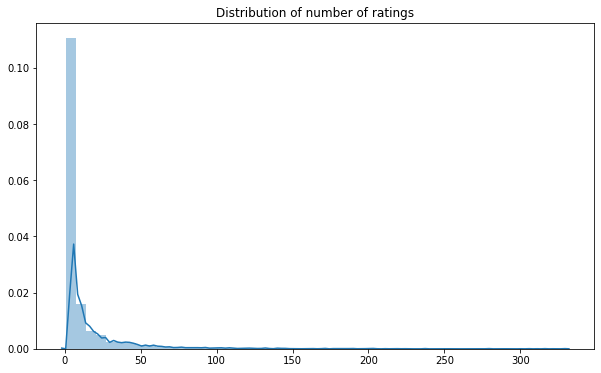

In [14]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_no_of_ratings.set_index("movieId"));
plt.title("Distribution of number of ratings");

In [15]:
df_no_of_ratings.describe()

,movieId,no_of_ratings
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


Set lower threshold for no_of_ratings to be considered for recommendations

In [16]:
min_no_of_ratings = 5
movies = df[df["no_of_ratings"] >= 5].copy()

In [17]:
movies.head()

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215.0
1,1,Toy Story (1995),5.0,4.0,215.0
2,1,Toy Story (1995),7.0,4.5,215.0
3,1,Toy Story (1995),15.0,2.5,215.0
4,1,Toy Story (1995),17.0,4.5,215.0


In [18]:
movies["movieId"].nunique()

3650

In [19]:
movie_features = movies.pivot_table(index="movieId",
                                    columns="userId",
                                    values="rating").fillna(0)

In [20]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Modelling

In [21]:
from scipy.sparse import csr_matrix

In [22]:
mat_movie_features = csr_matrix(movie_features)

## 3.1. Train KNN

K-Nearest-Neighbors

In [23]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [113]:
# export trained model as a pickle
import pickle

with open("movie_recommender/knn_model.pkl", "wb") as m:
    pickle.dump(model_knn, m, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
movie_features.loc[1].values.reshape(1, -1);

In [26]:
model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]]))

In [27]:
movie_features.iloc[1545]

userId
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    0.0
607.0    3.0
608.0    2.5
609.0    0.0
610.0    5.0
Name: 3114, Length: 610, dtype: float64

In [30]:
df_movies[df_movies["movieId"] == 3114]

,movieId,title
2355,3114,Toy Story 2 (1999)


In [31]:
movie_features.iloc[306]

userId
1.0      4.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    2.5
607.0    4.0
608.0    3.0
609.0    3.0
610.0    5.0
Name: 480, Length: 610, dtype: float64

In [118]:
with open("movie_recommender/movie_feature.pkl", "wb") as mf:
    pickle.dump(movie_features, mf, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
df_movies[df_movies["movieId"] == 480]

,movieId,title
418,480,Jurassic Park (1993)


Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the result with movieIds or titles, we need to translate the output.

# 4. Making our recommender more user-friendly

## 4.1. Translating recommendations to titles

In [33]:
distances, indeces = model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

**Create a mapping between movieId and title**

In [34]:
movie_list = movies[["movieId", "title"]].drop_duplicates().set_index("movieId")

In [117]:
with open("movie_recommender/movie_list.pkl", "wb") as ml:
    pickle.dump(movie_list, ml, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
indeces

array([[   0, 1545,  306,  429,  169,  231]])

the `indeces` array contains the positional indeces of the movies in the initial dataset used for training (`movie_features`). 

In [36]:
j = 0
for i in indeces.flatten():
    movie = movie_list.iloc[i,0]
    if j == 0:
        print(f"Recommendations for {movie}:")
        print("----------------------------------\n")
    else:
        print(f"{j}: {movie}")
    j += 1

Recommendations for Toy Story (1995):
----------------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


In [37]:
indeces.flatten()

array([   0, 1545,  306,  429,  169,  231])

In [38]:
distances.flatten()

array([0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
       0.45290409])

In [39]:
list(zip(indeces.flatten(), distances.flatten()))

[(0, 0.0),
 (1545, 0.4273987396802844),
 (306, 0.4343631959138433),
 (429, 0.43573830647233425),
 (169, 0.4426118294200634),
 (231, 0.4529040920598262)]

In [40]:
def print_recommendations(knn_output):
    distances, indeces = knn_output
    j = 0
    for i, distance in zip(indeces.flatten(), distances.flatten()):
        movie = movie_list.iloc[i,0]
        if j == 0:
            print(f"Recommendations for {movie}:")
            print("----------------------------------\n")
        else:
            print(f"{j}: {movie}, with distance {round(distance,2)}")
        j += 1

In [41]:
print_recommendations(model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6))

Recommendations for Toy Story (1995):
----------------------------------

1: Toy Story 2 (1999), with distance 0.43
2: Jurassic Park (1993), with distance 0.43
3: Independence Day (a.k.a. ID4) (1996), with distance 0.44
4: Star Wars: Episode IV - A New Hope (1977), with distance 0.44
5: Forrest Gump (1994), with distance 0.45


In [42]:
movie_list

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
...,...
180031,The Shape of Water (2017)
180985,The Greatest Showman (2017)
183897,Isle of Dogs (2018)


In [43]:
print_recommendations(model_knn.kneighbors(movie_features.loc[183897].values.reshape(1, -1), n_neighbors=6))

Recommendations for Isle of Dogs (2018):
----------------------------------

1: The Shape of Water (2017), with distance 0.46
2: Three Billboards Outside Ebbing, Missouri (2017), with distance 0.55
3: The Greatest Showman (2017), with distance 0.56
4: Hacksaw Ridge (2016), with distance 0.64
5: Creed (2015), with distance 0.66


## 4.2. Translating movieIds to movie-rating-vectors

In [44]:
def movieid_to_vector(movie_id):
    return movie_features.loc[movie_id].values.reshape(1, -1)

In [45]:
print_recommendations(model_knn.kneighbors(movieid_to_vector(3), 6))

Recommendations for Grumpier Old Men (1995):
----------------------------------

1: Grumpy Old Men (1993), with distance 0.55
2: Striptease (1996), with distance 0.55
3: Nutty Professor, The (1996), with distance 0.55
4: Twister (1996), with distance 0.56
5: Father of the Bride Part II (1995), with distance 0.58


In [46]:
def recommender(movie_id, n=5):
    recs = n + 1
    print_recommendations(model_knn.kneighbors(movieid_to_vector(movie_id), recs))

In [47]:
movie_list[999:1020]

,title
movieId,
1994,Poltergeist (1982)
1995,Poltergeist II: The Other Side (1986)
1997,"Exorcist, The (1973)"
2000,Lethal Weapon (1987)
2001,Lethal Weapon 2 (1989)
2002,Lethal Weapon 3 (1992)
2003,Gremlins (1984)
2004,Gremlins 2: The New Batch (1990)
2005,"Goonies, The (1985)"


In [48]:
recommender(2011)

Recommendations for Back to the Future Part II (1989):
----------------------------------

1: Back to the Future Part III (1990), with distance 0.22
2: Back to the Future (1985), with distance 0.34
3: Indiana Jones and the Temple of Doom (1984), with distance 0.38
4: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.43
5: Minority Report (2002), with distance 0.45


In [49]:
recommender(2005)

Recommendations for Goonies, The (1985):
----------------------------------

1: Gremlins (1984), with distance 0.46
2: Hook (1991), with distance 0.46
3: Ferris Bueller's Day Off (1986), with distance 0.47
4: Indiana Jones and the Temple of Doom (1984), with distance 0.48
5: Willow (1988), with distance 0.49


In [ ]:
lemon weapon -> lethal weapon (1987) -> 2000 

In [50]:
recommender(2000)

Recommendations for Lethal Weapon (1987):
----------------------------------

1: RoboCop (1987), with distance 0.34
2: Lethal Weapon 2 (1989), with distance 0.39
3: Indiana Jones and the Temple of Doom (1984), with distance 0.4
4: Escape from New York (1981), with distance 0.42
5: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.44


## 4.2. Allow title queries as input

Extend on the previous example to allow input as title instead of movieId. We're building a super simple 'search engine'.

We need a flexible mapping from title to movieId.

In [52]:
movie_list.head()

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [56]:
movie_index = {title: idx for idx, title in movie_list.to_dict()["title"].items()}

In [115]:
with open("movie_recommender/movie_index.pkl", "wb") as mi:
    pickle.dump(movie_index, mi, protocol=pickle.HIGHEST_PROTOCOL)

---

### Quick intro to fuzzy string matching so we can introduce tolerance to search queries

In [57]:
from fuzzywuzzy import fuzz

In [64]:
fuzz.ratio("Hello", "Hello")

100

In [59]:
fuzz.ratio("Hillo", "Hello")

80

In [60]:
fuzz.ratio("father of the bride", "Father of the Bride Part II (1995)")

67

In [61]:
fuzz.ratio("father of the bride", "Grumpier Old Men (1995)")

29

In [62]:
fuzz.ratio("father of the bride".lower(), "Father of the Bride Part II".lower())

83

---

In [65]:
import re

In [66]:
fav_movie = "drive"

using string input, find the strings that closest match the input based on the levenshtein distance

In [70]:
t = "Grumpier Old Men (1995)"
t_pattern = r"(.*)\s\(\d{4}\)$"
extr_t, = re.findall(t_pattern, t)
extr_t

'Grumpier Old Men'

In [71]:
matches = []
for title, movie_id in movie_index.items():
    # remove the year
    title_pattern = r"(.*)\s\(\d{4}\)$"
    extr_title, = re.findall(title_pattern, title)
    
    # compute ratio and remove case-sensitivity
    ratio = fuzz.ratio(extr_title.lower(), fav_movie.lower())
    
    # add all matches to list with ratio > 60
    if ratio >= 60:
        matches.append((title, movie_id, ratio))

In [72]:
matches

[('Taxi Driver (1976)', 111, 62),
 ('Dave (1993)', 440, 67),
 ('Eddie (1996)', 656, 60),
 ('Diva (1981)', 1264, 67),
 ('Alive (1993)', 3250, 60),
 ('Diner (1982)', 3543, 60),
 ('Driven (2001)', 4265, 91),
 ('Drumline (2002)', 5941, 62),
 ('Prime (2005)', 39449, 60),
 ('Drive (2011)', 88129, 100),
 ('Brave (2012)', 95167, 60),
 ('Dredd (2012)', 96737, 60),
 ('Baby Driver (2017)', 171763, 62),
 ('Wind River (2017)', 175569, 67)]

In [77]:
sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

88129

In [78]:
recommender(88129)

Recommendations for Drive (2011):
----------------------------------

1: Cabin in the Woods, The (2012), with distance 0.42
2: Seven Psychopaths (2012), with distance 0.44
3: Up in the Air (2009), with distance 0.44
4: Prometheus (2012), with distance 0.44
5: In Bruges (2008), with distance 0.45


In [103]:
def find_movie_id(query):
    matches = []
    for title, movie_id in movie_index.items():
        # remove the year
        title_pattern = r"(.*)\s\(\d{4}\)$"
        extr_title, = re.findall(title_pattern, title)

        # compute ratio and remove case-sensitivity
        ratio = fuzz.ratio(extr_title.lower(), query.lower())

        # add all matches to list with ratio > 60
        if ratio >= 60:
            matches.append((title, movie_id, ratio))
            
    if len(matches) == 0:
        print("Sorry, could not find your movie :(")
        return
    
    return sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

In [81]:
recommender(find_movie_id("drive"))

Recommendations for Drive (2011):
----------------------------------

1: Cabin in the Woods, The (2012), with distance 0.42
2: Seven Psychopaths (2012), with distance 0.44
3: Up in the Air (2009), with distance 0.44
4: Prometheus (2012), with distance 0.44
5: In Bruges (2008), with distance 0.45


In [107]:
def recommender(movie_title, n=5):
    movie_id = find_movie_id(movie_title)
    if movie_id is None:
        return 
    
    recs = n + 1
    print_recommendations(model_knn.kneighbors(movieid_to_vector(movie_id), recs))

In [83]:
recommender("lethal weapon")

Recommendations for Lethal Weapon (1987):
----------------------------------

1: RoboCop (1987), with distance 0.34
2: Lethal Weapon 2 (1989), with distance 0.39
3: Indiana Jones and the Temple of Doom (1984), with distance 0.4
4: Escape from New York (1981), with distance 0.42
5: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.44


In [84]:
recommender("limon weapon")

Recommendations for Lethal Weapon (1987):
----------------------------------

1: RoboCop (1987), with distance 0.34
2: Lethal Weapon 2 (1989), with distance 0.39
3: Indiana Jones and the Temple of Doom (1984), with distance 0.4
4: Escape from New York (1981), with distance 0.42
5: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.44


In [85]:
recommender("back to the future 2")

Recommendations for Back to the Future (1985):
----------------------------------

1: Star Wars: Episode VI - Return of the Jedi (1983), with distance 0.33
2: Back to the Future Part II (1989), with distance 0.34
3: Star Wars: Episode V - The Empire Strikes Back (1980), with distance 0.35
4: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance 0.36
5: Back to the Future Part III (1990), with distance 0.36


In [87]:
recommender("frozen")

Recommendations for Frozen (2013):
----------------------------------

1: Brave (2012), with distance 0.44
2: Tangled (2010), with distance 0.49
3: Bolt (2008), with distance 0.51
4: Pitch Perfect (2012), with distance 0.54
5: Toy Story 3 (2010), with distance 0.54


In [88]:
recommender("up")

Recommendations for Up (2009):
----------------------------------

1: WALL·E (2008), with distance 0.31
2: Avatar (2009), with distance 0.37
3: Inception (2010), with distance 0.39
4: Iron Man (2008), with distance 0.4
5: Dark Knight, The (2008), with distance 0.42


In [108]:
recommender("harry potter")

Sorry, could not find your movie :(


In [109]:
recommender("satantango")

Recommendations for Fandango (1985):
----------------------------------

1: My Bodyguard (1980), with distance 0.35
2: Eat Drink Man Woman (Yin shi nan nu) (1994), with distance 0.44
3: Fireworks (Hana-bi) (1997), with distance 0.45
4: Married to the Mob (1988), with distance 0.46
5: Ice Storm, The (1997), with distance 0.47


In [110]:
recommender("opening night")

Recommendations for Big Night (1996):
----------------------------------

1: Farewell My Concubine (Ba wang bie ji) (1993), with distance 0.45
2: Marvin's Room (1996), with distance 0.46
3: Sleeping with the Enemy (1991), with distance 0.46
4: Spellbound (1945), with distance 0.49
5: Brassed Off (1996), with distance 0.5


In [111]:
recommender("marriage story")

Recommendations for American History X (1998):
----------------------------------

1: Fight Club (1999), with distance 0.35
2: American Beauty (1999), with distance 0.41
3: Goodfellas (1990), with distance 0.43
4: Memento (2000), with distance 0.43
5: Reservoir Dogs (1992), with distance 0.43
